In [1]:
import scanpy as sc
import tcri
import pandas as pd
from genevector.data import GeneVectorDataset
from genevector.model import GeneVector
from genevector.embedding import GeneEmbedding, CellEmbedding
import grimoire as spell
import os
import matplotlib.pyplot as plt
import shutil

In [2]:
adata = sc.read("/Users/ceglian/Data/tcri/zhang/zhang_pp.h5ad")

ct = []
for x,y in zip(adata.obs["timepoint"],adata.obs["patient"]):
    if y == "P13" and x == "post.2":
        ct.append("post.3")
    else:
        ct.append(x)
adata.obs["timepoint"] = ct

ct = []
for x in adata.obs["timepoint"]:
    if "pre" in x:
        ct.append("Pre-treatment")
    else:
        ct.append("Post-treatment")
adata.obs["timepoint_simple"] = ct

ct = []
for x in adata.obs["response"]:
    if "None" in x:
        ct.append("Treatment-Naive")
    else:
        ct.append("On-treatment")
adata.obs["treatment"] = ct

In [3]:
#any without signed mi were  false
signed_mi          = True
init_ortho         = True
entropy_threshold  = 1.5
mutual_information = "/Users/ceglian/Data/tcri/zhang_cd8_{}_{}.p".format(signed_mi,str(entropy_threshold).replace(".",""))
print(mutual_information)
embedding_size     = 100
alpha              = 0.08
beta               = 0.02
gain               = 10
vector_file        = "/Users/ceglian/Data/tcri/zhang_cd8_{}_{}_{}_{}_{}_{}.vec".format(embedding_size, alpha, beta, gain, signed_mi, init_ortho)
print(vector_file)
retrain            = True
annotated_h5ad     = "/Users/ceglian/Data/tcri/zhang_annotated.h5ad"
device             = "cpu"
figure_path = "/Users/ceglian/Data/tcri/zhang/figures/"

/Users/ceglian/Data/tcri/zhang_cd8_True_15.p
/Users/ceglian/Data/tcri/zhang_cd8_100_0.08_0.02_10_True_True.vec


In [4]:
genes = [x for x in adata.var.index.tolist()]
genes = [x for x in genes if "TRAV" not in x]
genes = [x for x in genes if "TRAJ" not in x]
genes = [x for x in genes if "TRAD" not in x]


genes = [x for x in genes if "TRBV" not in x]
genes = [x for x in genes if "TRBJ" not in x]
genes = [x for x in genes if "TRBD" not in x]

genes = [x for x in genes if "TRGV" not in x]
genes = [x for x in genes if "TRGJ" not in x]
genes = [x for x in genes if "TRGD" not in x]

genes = [x for x in genes if "TRDV" not in x]
genes = [x for x in genes if "TRDJ" not in x]
genes = [x for x in genes if "TRDD" not in x]

adata = adata[adata.obs["trb"]!=""]
adata = adata[adata.obs["trb"]!="nan"]
adata = adata[adata.obs["trb"]!="Other"]

adata = adata[:,genes]

adata = spell.pp.remove_meaningless_genes(adata)
tcri.pp.gene_entropy(adata)
adata = adata[:,adata.var["entropy"] > entropy_threshold]
adata.var

100%|██████████| 19264/19264 [00:14<00:00, 1342.83it/s]


entropy
ISG15     1.858449
TNFRSF18  2.115975
TNFRSF4   2.379996
ENO1      1.572219
ID3       1.554085
...            ...
GTSE1     1.564562
SAMSN1    1.791777
SOD1      2.123625
MX1       1.500491
S100B     1.834191

[356 rows x 1 columns]

In [5]:
tcri.pp.register_clonotype_key(adata,"trb")

In [6]:
dataset = GeneVectorDataset(adata,load_expression=False,signed_mi=signed_mi,device=device)

Running...
Skipping expression load.


In [7]:
embed = GeneEmbedding(vector_file, dataset, vector="average")
cembed = CellEmbedding(dataset, embed)
adata = cembed.get_adata()
adata

Loading average of 1st and 2nd weights.


100%|██████████| 15252980/15252980 [00:23<00:00, 644050.11it/s]


Generating Cell Vectors.


100%|██████████| 77030/77030 [00:05<00:00, 14047.07it/s]


Found 0 Cells with No Counts.
Finished.
Loading embedding in X_genevector.
Running Scanpy neighbors and umap.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


AnnData object with n_obs × n_vars = 77030 × 356
    obs: 'patient', 'sample', 'celltype', 'cluster', 'trb', 'response', 'timepoint', 'timepoint_simple', 'treatment'
    var: 'entropy'
    uns: 'tcri_clone_key', 'tcri_unique_clonotypes', 'neighbors', 'umap'
    obsm: 'X_genevector', 'X_umap'
    obsp: 'distances', 'connectivities'

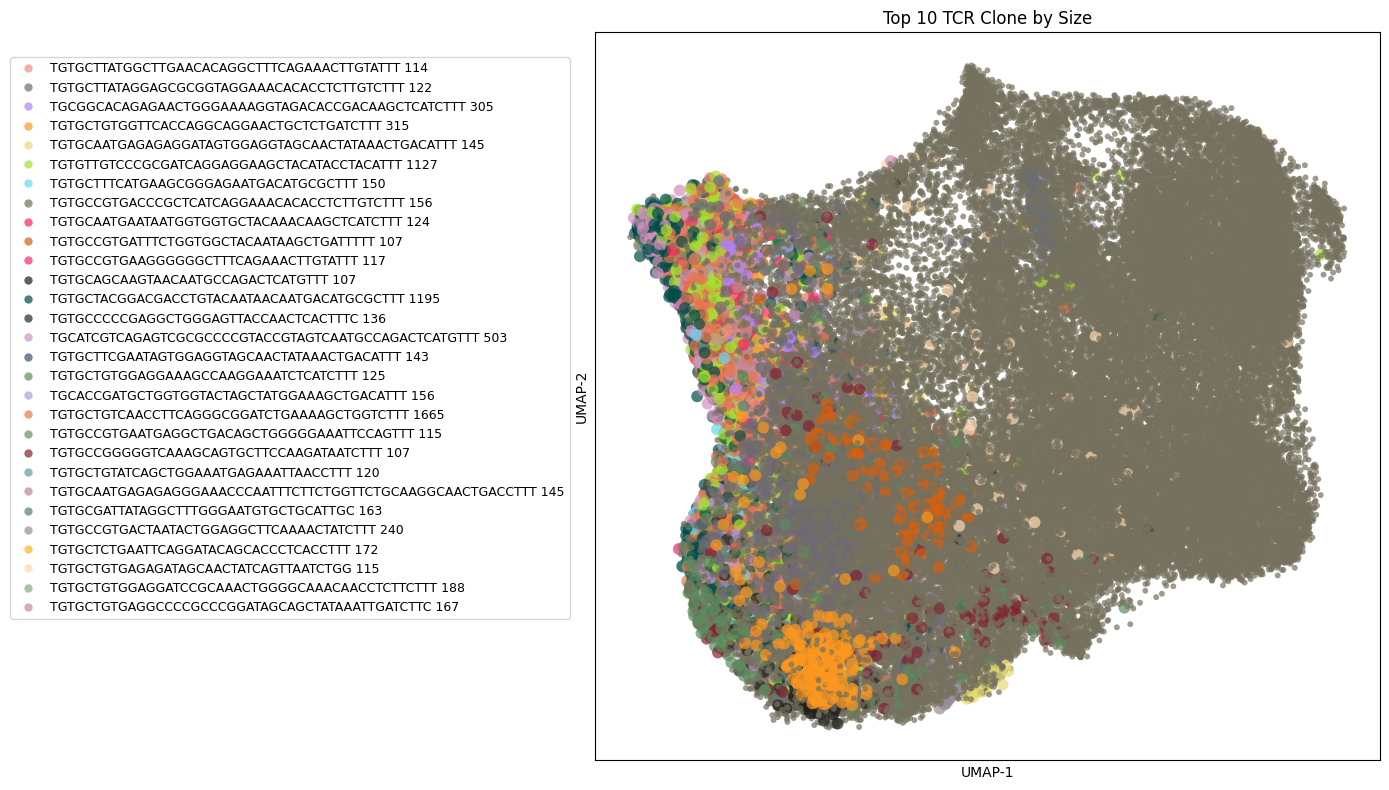

In [8]:
tcri.pl.top_clone_umap(adata,top_n=30,size=5,figsize=(14,8),bg_size=0)

<Axes: xlabel='UMAP-1', ylabel='UMAP-2'>

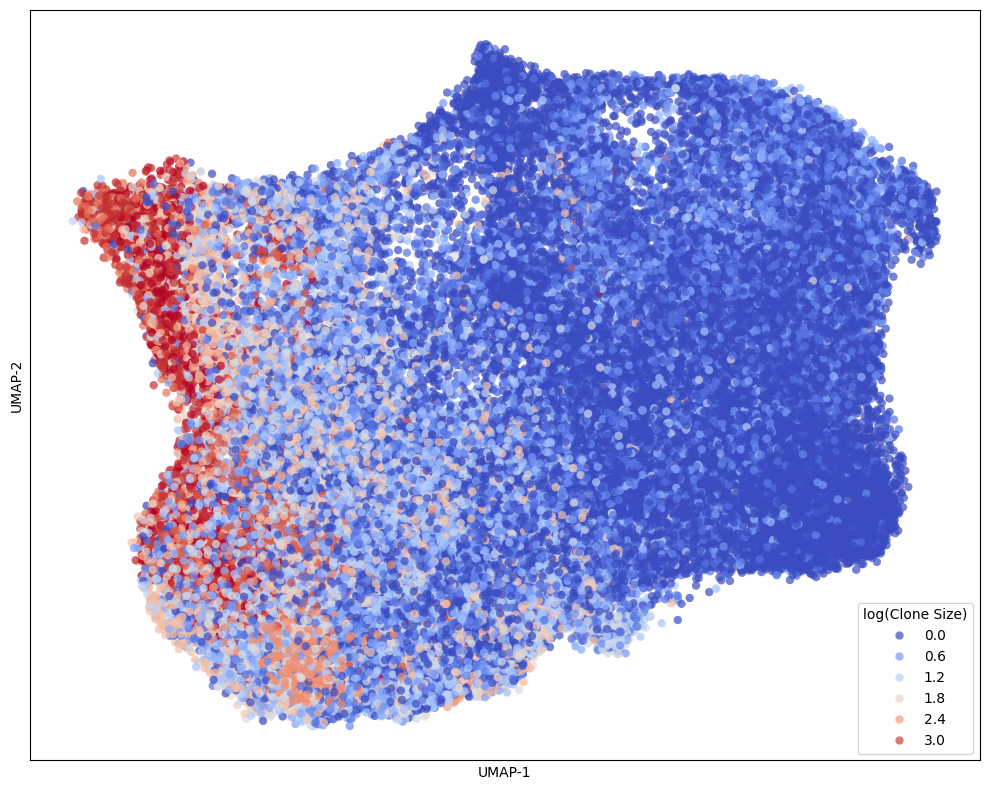

In [9]:
tcri.pl.clone_size_umap(adata,figsize=(14,8))

In [10]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [12]:
adata.write("/Users/ceglian/parsed.h5ad")

In [11]:
markers = dict()
markers["Naive"] = ["IL7R"]
markers["Memory"] = ["GZMK"]
markers["Activated"] = ["GZMB"]
markers["Dysfunctional"] = ["CXCL13"]
adata, dist = cembed.phenotype_probability(adata, markers, method="normalized_exponential",temperature=0.01, return_distances=True)

Using Normalized Exponential (Temp: 0.01)
Computing similarities for Naive
Markers: IL7R


100%|██████████| 77030/77030 [00:01<00:00, 75505.26it/s]


Computing similarities for Memory
Markers: GZMK


100%|██████████| 77030/77030 [00:00<00:00, 78962.37it/s]


Computing similarities for Activated
Markers: GZMB


100%|██████████| 77030/77030 [00:01<00:00, 76733.73it/s]


Computing similarities for Dysfunctional
Markers: CXCL13


100%|██████████| 77030/77030 [00:00<00:00, 78421.82it/s]


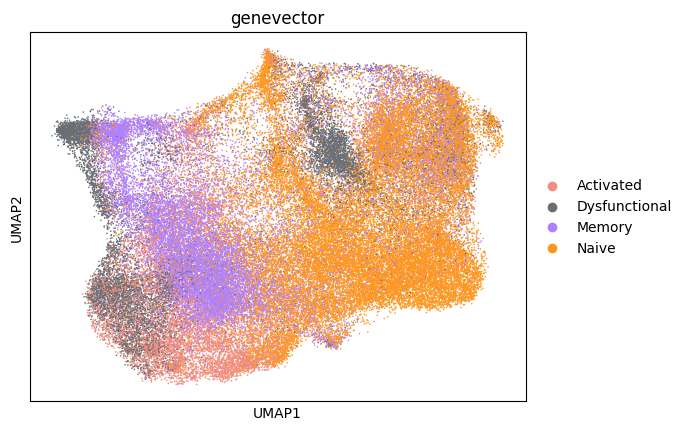

'/Users/ceglian/Data/tcri/zhang/figures/zhang.pdf'

In [13]:
sc.pl.umap(adata,color="genevector",s=5,save="zhang.pdf")
shutil.copyfile("figures/umapzhang.pdf",os.path.join(figure_path,"zhang.pdf"))

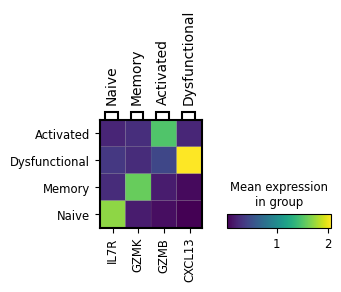

In [14]:
sc.pl.matrixplot(adata,markers,groupby="genevector")
#shutil.copyfile("figures/umapzhang.pdf",figure_path)

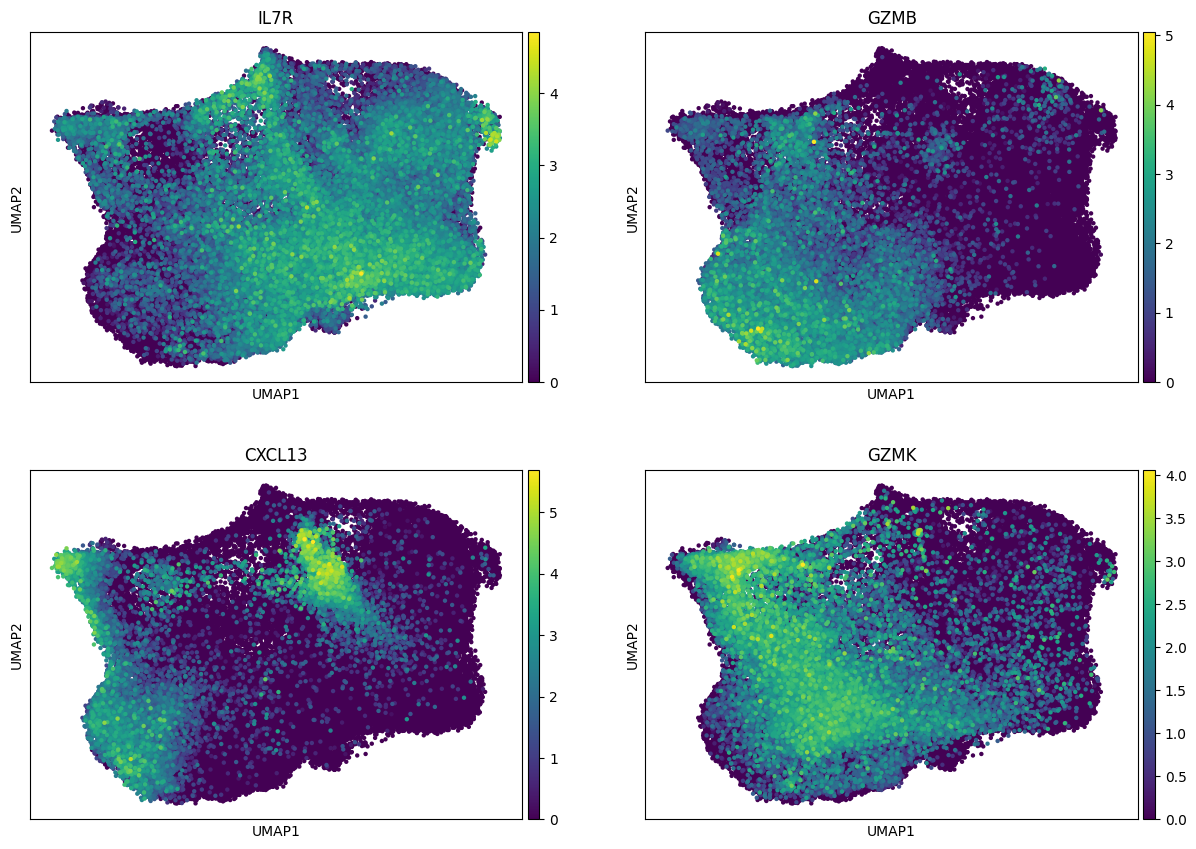

'/Users/ceglian/Data/tcri/zhang/figures/umapzhang_markers.pdf'

In [15]:
sc.pl.umap(adata,color=["IL7R","GZMB","CXCL13","GZMK"],ncols=2,s=40, save="zhang_markers.pdf")
shutil.copyfile("figures/umapzhang_markers.pdf",os.path.join(figure_path, "umapzhang_markers.pdf"))

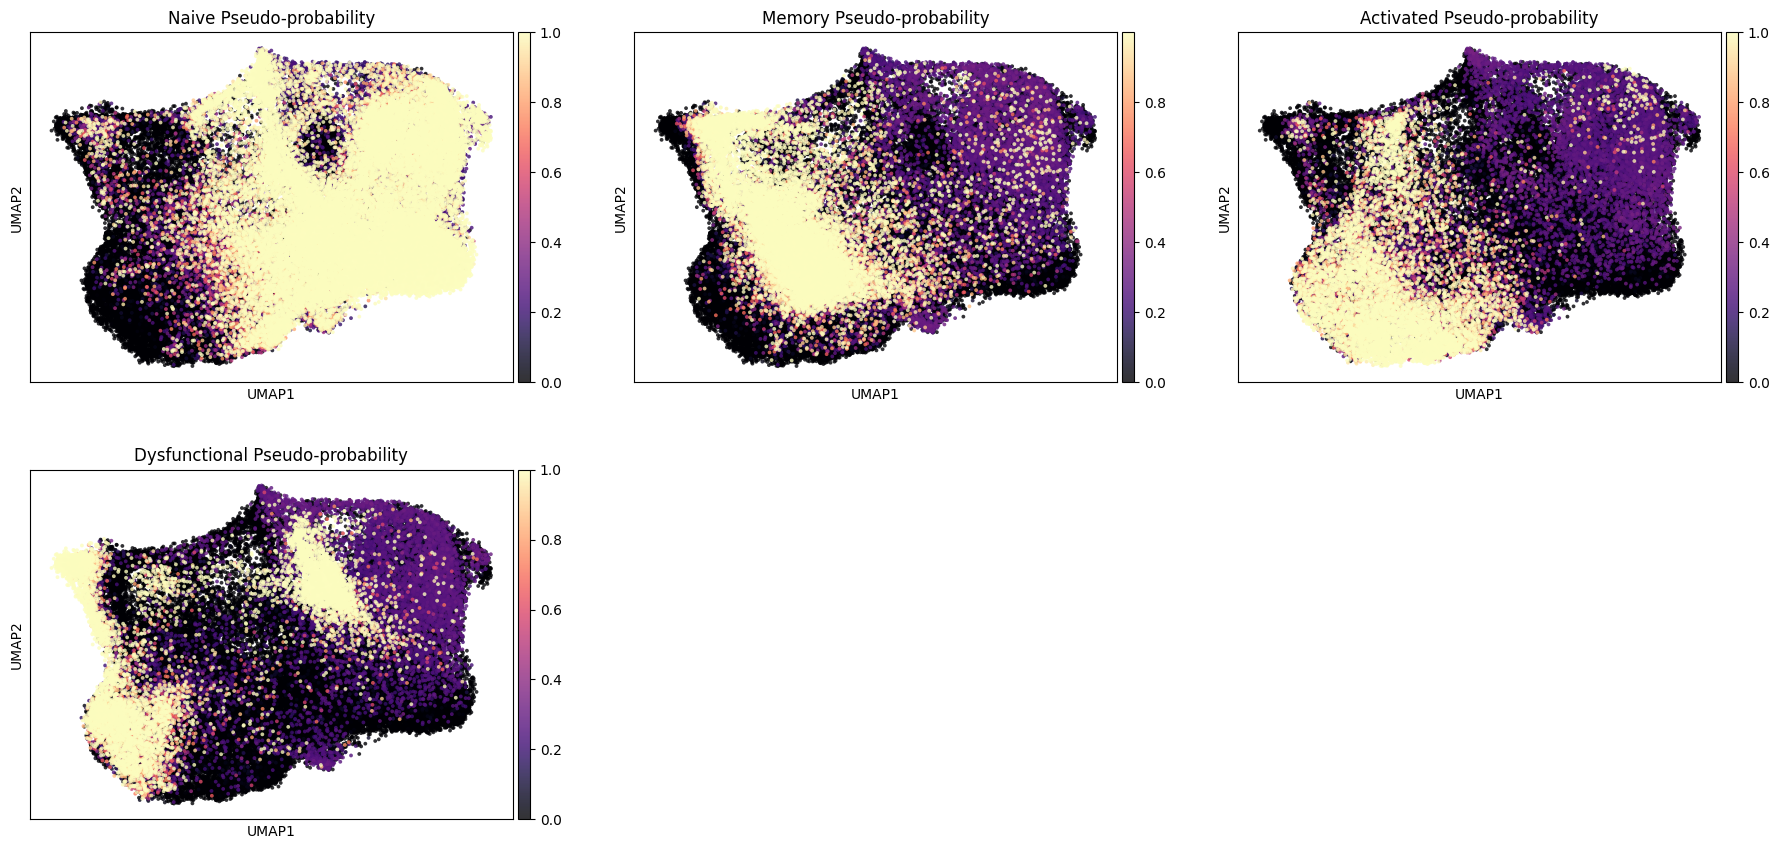

'/Users/ceglian/Data/tcri/zhang/figures/umapprobs.pdf'

In [16]:
cembed.plot_probabilities(adata)
shutil.copyfile("figures/umapprobs.pdf",os.path.join(figure_path,"umapprobs.pdf"))

In [17]:
tcri.pp.clone_size(adata)

In [18]:
tcri.pp.register_phenotype_key(adata,"genevector")

['Naive', 'Memory', 'Dysfunctional', 'Activated']


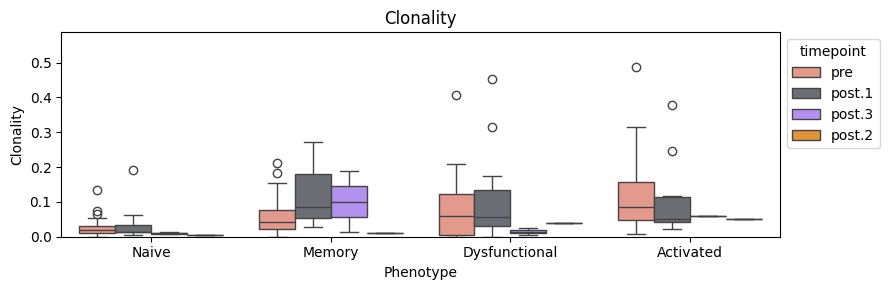

In [21]:
tcri.pl.clonality(adata,groupby="patient",figsize=(9,3),splitby="timepoint",order=["Naive","Memory","Dysfunctional","Activated"])
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/clonality.pdf")

['Naive', 'Memory', 'Dysfunctional', 'Activated']


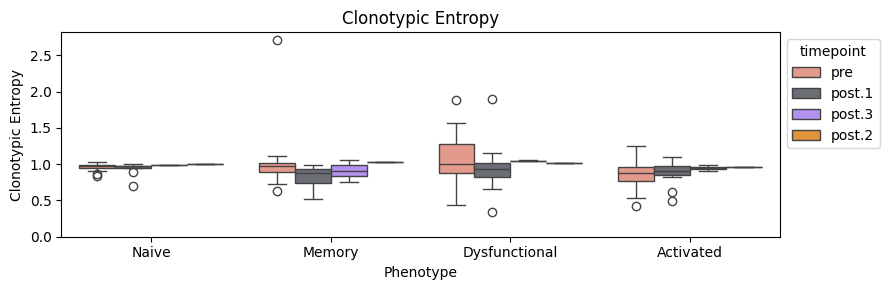

In [20]:
tcri.pl.clonotypic_entropy(adata,groupby="patient",figsize=(9,3),method="probabilistic",splitby="timepoint",normalized=True,order=["Naive","Memory","Dysfunctional","Activated"])
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/clonotypic_entropy.pdf")

In [28]:
tcri.tl.clonotypic_entropy(adata,phenotype="Dysfunctional", normalized=True)

0.737666864862926

In [148]:

import numpy as np
from collections import Counter

def compute_clonality(tcr_sequences):
    sequence_counts = Counter(tcr_sequences)
    total_sequences = sum(sequence_counts.values())
    probabilities = [count / total_sequences for count in sequence_counts.values()]
    shannon_entropy = -sum(p * np.log2(p) for p in probabilities if p > 0)
    max_entropy = np.log2(len(sequence_counts))
    print(len(sequence_counts))
    normalized_entropy = shannon_entropy / max_entropy if max_entropy > 0 else 1
    clonality = 1 - normalized_entropy
    return clonality

def compute_clonality_with_probabilities(clone_probabilities):
    total_probability = sum(clone_probabilities.values())
    if total_probability != 1:
        clone_probabilities = {clone: prob / total_probability for clone, prob in clone_probabilities.items()}
    shannon_entropy = -sum(p * np.log2(p) for p in clone_probabilities.values() if p > 0)
    max_entropy = np.log2(len(clone_probabilities))
    normalized_entropy = shannon_entropy / max_entropy if max_entropy > 0 else 1
    clonality = 1 - normalized_entropy
    return clonality


In [160]:
act = adata[adata.obs["genevector"] == "Activated"]
tcri.pp.joint_distribution(act)

In [165]:
act = adata[adata.obs["genevector"] == "Activated"]
tcri.pp.joint_distribution(act,method="probabilistic")
1-compute_clonality(act.obs["trb"].tolist())

6040


0.8984124628817702

In [172]:
act = adata[adata.obs["genevector"] == "Dysfunctional"]
tcri.pp.joint_distribution(act,method="probabilistic")
# actp = dict(zip(act.obs["trb"].tolist(), act.obs["Dysfunctional Pseudo-probability"].tolist()))
# print(actp)
1-compute_clonality_with_probabilities(actp)

{'TGTGCTCTAAGTGGTAGAAGAGGCTCAACCCTGGGGAGGCTATACTTT': 0.26856024247683075, 'TGTGCTCTGACGGGGGGTGGAGGTAGCAACTATAAACTGACATTT': 0.9372179112482055, 'TGTGCTCTTAGAGGGAATAACAATGCCAGACTCATGTTT': 0.8808514891747892, 'TGTGCTGTGAGTGTAGGGGGCTCAGGAGGAAGCTACATACCTACATTT': 0.2875337886684439, 'TGTGCTGTGGTCCGATCTAACTTTGGAAATGAGAAATTAACCTTT': 0.9999992110680176, 'TGTGCAGCAAGCTCAGGAACCTACAAATACATCTTT': 0.999113648894247, 'TGTGCTACGGTCGGTAACCAGTTCTATTTT': 0.9918134186720372, 'TGTGCAATGAGGAAGAATTCTGGGGGTTACCAGAAAGTTACCTTT': 0.2645749783963878, 'TGTGCAGAGCCGAGGAATTCAGGAAACACACCTCTTGTCTTT': 0.9709269518802427, 'TGTGCCGTGGACACCTACTCAGGAACCTACAAATACATCTTT': 0.9999999471322734, 'TGTGCTGCCCCGGTTCAGGGAGCCCAGAAGCTGGTATTT': 0.6991439813213578, 'TGTGCTTTCATGAAGAGTCAGTTCTATTTT': 0.34948139389063415, 'TGTGCTGTGAGTCAGGATACTGGAGGCTTCAAAACTATCTTT': 0.2850568682647177, 'TGTGCAGCAAGCACAGGAACCTACAAATACATCTTT': 0.9999999899755364, 'TGTGCAGCAGGCAGAGGCTCAACCCTGGGGAGGCTATACTTT': 0.30573013828008955, 'TGTGGCACAGAGACTAACGACTACAAG

0.9873821517759326

In [173]:
act = adata[adata.obs["genevector"] == "Dysfunctional"]
tcri.pp.joint_distribution(act,method="empirical")
actp = dict(zip(act.obs["trb"].tolist(), act.obs["Dysfunctional Pseudo-probability"].tolist()))
print(actp)
1-compute_clonality_with_probabilities(actp)

{'TGTGCTCTAAGTGGTAGAAGAGGCTCAACCCTGGGGAGGCTATACTTT': 0.26856024247683075, 'TGTGCTCTGACGGGGGGTGGAGGTAGCAACTATAAACTGACATTT': 0.9372179112482055, 'TGTGCTCTTAGAGGGAATAACAATGCCAGACTCATGTTT': 0.8808514891747892, 'TGTGCTGTGAGTGTAGGGGGCTCAGGAGGAAGCTACATACCTACATTT': 0.2875337886684439, 'TGTGCTGTGGTCCGATCTAACTTTGGAAATGAGAAATTAACCTTT': 0.9999992110680176, 'TGTGCAGCAAGCTCAGGAACCTACAAATACATCTTT': 0.999113648894247, 'TGTGCTACGGTCGGTAACCAGTTCTATTTT': 0.9918134186720372, 'TGTGCAATGAGGAAGAATTCTGGGGGTTACCAGAAAGTTACCTTT': 0.2645749783963878, 'TGTGCAGAGCCGAGGAATTCAGGAAACACACCTCTTGTCTTT': 0.9709269518802427, 'TGTGCCGTGGACACCTACTCAGGAACCTACAAATACATCTTT': 0.9999999471322734, 'TGTGCTGCCCCGGTTCAGGGAGCCCAGAAGCTGGTATTT': 0.6991439813213578, 'TGTGCTTTCATGAAGAGTCAGTTCTATTTT': 0.34948139389063415, 'TGTGCTGTGAGTCAGGATACTGGAGGCTTCAAAACTATCTTT': 0.2850568682647177, 'TGTGCAGCAAGCACAGGAACCTACAAATACATCTTT': 0.9999999899755364, 'TGTGCAGCAGGCAGAGGCTCAACCCTGGGGAGGCTATACTTT': 0.30573013828008955, 'TGTGGCACAGAGACTAACGACTACAAG

0.9873821517759326

In [29]:
# import numpy as np
# import math

# from scipy.stats import entropy
# import numpy as np
# import operator
# from scipy.spatial import distance
# import pandas as pd
# import warnings
# import gseapy as gp
# import math
# import pandas as pd
# from scipy.stats import entropy
# from scipy.stats import entropy
# import numpy

# def clonotypic_entropy(adata, phenotype, method="probabilistic", base=2, normalized=False):
#     logf = lambda x : np.log(x) / np.log(base)
#     tcri.pp.joint_distribution(adata, method=method)
#     jd = adata.uns['joint_distribution']
#     res = jd.loc[phenotype].to_numpy()
#     cent = entropy(res,base=base)
#     if normalized:
#         cent = cent / logf(np.sum(res))
#     return cent

# def clonality(adata):
#     phenotypes = adata.obs[adata.uns["tcri_phenotype_key"]].tolist()
#     unique_phenotypes = np.unique(phenotypes)
#     entropys = dict()
#     df = adata.obs.copy()
#     for phenotype in unique_phenotypes:
#         pheno_df = df[df[adata.uns['tcri_phenotype_key']]==phenotype]
#         clonotypes = pheno_df[adata.uns["tcri_clone_key"]].tolist()
#         unique_clonotypes = np.unique(clonotypes)
#         nums = []
#         for tcr in unique_clonotypes:
#             tcrs = pheno_df[pheno_df[adata.uns["tcri_clone_key"]]==tcr]
#             nums.append(len(tcrs))
#         clonality = 1 - entropy(numpy.array(nums),base=2) / numpy.log2(len(nums))
#         entropys[phenotype] = numpy.nan_to_num(clonality)
#     return entropys

for x in set(adata.obs["genevector"]):
    cent = tcri.tl.clonotypic_entropy(adata,x,normalized=True)
    ct = 1-tcri.tl.clonality(adata)[x]
    print(x,cent,ct,cent-ct)

Naive 0.9586792132667978 0.9748843536005174 -0.01620514033371956
Memory 0.8364132737880365 0.8896811876696934 -0.05326791388165686
Dysfunctional 0.737666864862926 0.7710985467844061 -0.03343168192148016
Activated 0.8583059729910085 0.8984124628818033 -0.040106489890794794


In [231]:
# # matrix = adata.obs[adata.uns["probability_columns"]]
# # matrix["clonotype"] = adata.obs[adata.uns["tcri_clone_key"]]
# # jd = matrix.groupby("clonotype").sum().T
# # jd.index = [i.replace(" Pseudo-probability","") for i in jd.index]
# # jd = np.round(jd,decimals=5)
# base = 2


0.8583059729910085

In [232]:
# tcri.pp.joint_distribution(adata, method="empirical")
# jd = adata.uns['joint_distribution']
# res = jd.loc["Activated"].to_numpy()
# from scipy.stats import entropy
# entropy(res,base=2) / np.log2(np.sum(res))

0.8294899386945026

0.8361474655980078 0.12347522000485056
1.0975797379324177 0.021743174866183046
0.8034860717497 0.17234988231731307
0.9539650433301411 0.0386049498291845
1.1695523004137154 0.011199304960032408
0.7954286309895867 0.1298586994454637
0.9477937186510657 0.0393448440758849
1.030707663161308 0.016396911922188062
0.7977189639093004 0.1064074102187208
1.0098738263221227 0.04818645608519756
0.6543563674122496 0.23984862487277492
0.8962895109454199 0.0781632213910981
0.8531925766076165 0.09695532960249564
0.9134678143957486 0.06339480052551316
0.7590245027769396 0.15074083067066524
0.9674501382341347 0.05167670533072932
0.8486501230192964 0.09087651081085191
0.9420575845521003 0.05226007938734789
0.4212683853133613 0.4868899006193941
1.0761177246977678 0.017483781738850568
0.6140450423255917 0.2100997349560404
0.4975906945331072 0.37839182982511244
1.059894177472635 0.048359614658294525
0.7291501826080106 0.17431300724048404
0.7412264634658992 0.19276791869616217
0.8293576574651488 0.11501593851

Text(0.5, 0, 'Clonality')

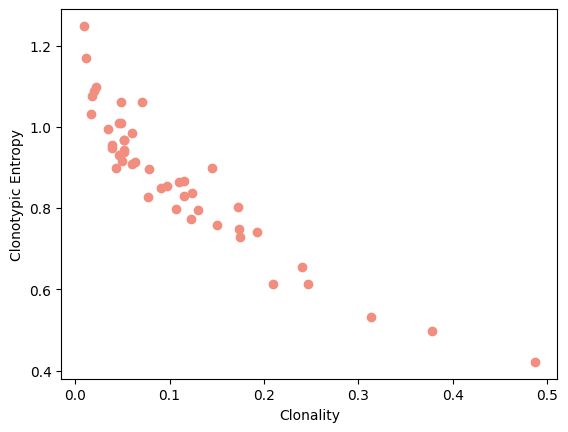

In [31]:
x = []
y = []
for p in set(adata.obs["patient"]):
    sub = adata[adata.obs["patient"] == p]
    for tp in set(sub.obs["timepoint"]):
        subx = sub[sub.obs["timepoint"] == tp]
        cent = tcri.tl.clonotypic_entropy(subx,"Activated",normalized=True)
        clonality = tcri.tl.clonality(subx)["Activated"]
        x.append(cent)
        y.append(clonality)
        print(cent,clonality)
plt.scatter(y,x)
plt.ylabel("Clonotypic Entropy")
plt.xlabel("Clonality")

In [ ]:
from scipy.stats import entropy
import numpy as np
import operator
from scipy.spatial import distance
import pandas as pd
import warnings
import gseapy as gp
import math
import pandas as pd

from scipy.stats import entropy
import numpy

def clonotypic_entropy(adata, phenotype, method="probabilistic", base=2, normalized=False):
    logf = lambda x : np.log(x) / np.log(base)
    tcri.pp.joint_distribution(adata, method=method)
    jd = adata.uns['joint_distribution']
    res = jd.loc[phenotype].to_numpy()
    cent = entropy(res,base=base)
    if normalized:
        cent = cent / logf(np.sum(res))
    return cent

In [76]:
tcri.tl.phenotypic_entropy(adata)

1.9887592544435162

0.0
1.0 1.0
8.776500816098931e-07
0.95569 0.9556891223499184
9.593901043603026e-07
0.92576 0.9257590406098957
-2.9743571993146034e-06
0.99072 0.9907229743571994
-6.443658568944244e-07
0.94408 0.9440806443658569
-9.479993202665682e-07
0.89826 0.8982609479993202
-7.201499985232118e-07
0.88536 0.8853607201499986
2.6694202907018294e-06
0.98018 0.9801773305797093
1.429973000344198e-06
0.95297 0.9529685700269996
-3.899334174550795e-06
0.84572 0.8457238993341746
-2.575980280750123e-06
0.83874 0.8387425759802808
-4.108495839760806e-06
0.97192 0.9719241084958398
-8.190052420697924e-07
0.97724 0.9772408190052421
-3.121272651229745e-06
0.98774 0.9877431212726512
1.589821351788423e-06
0.98955 0.9895484101786483
-4.293380497566446e-06
0.97182 0.9718242933804976
4.580634620610091e-06
0.96019 0.9601854193653794
5.989054737698396e-07
0.95939 0.9593894010945262
3.6392730798917583e-06
0.81629 0.8162863607269201
7.865289209929571e-07
0.9759 0.975899213471079
1.1144423612829968e-06
0.98657 0.9865688855576

Text(0.5, 1.0, 'Memory')

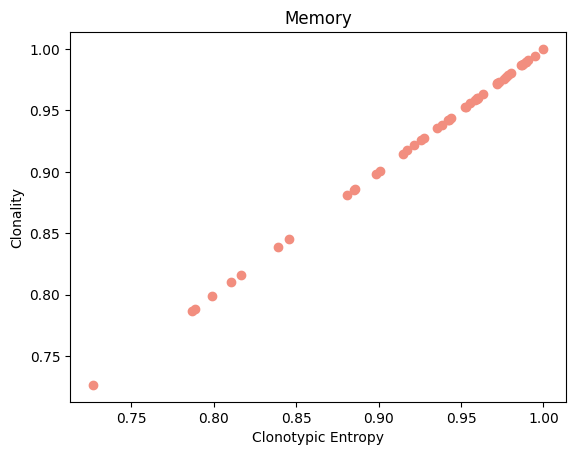

In [77]:
x = []
y = []
for p in set(adata.obs["patient"]):
    sub = adata[adata.obs["patient"] == p]
    for tp in set(sub.obs["timepoint"]):
        subx = sub[sub.obs["timepoint"] == tp]
        subxm = subx[subx.obs["genevector"] == "Memory"]
        cent = tcri.tl.clonotypic_entropies(subxm,normalized=True)["Memory"]
        clonality = 1-tcri.tl.clonality(subx)["Memory"]
        x.append(cent)
        y.append(clonality)
        print(cent-clonality)
        print(cent,clonality)
plt.scatter(x,y)
plt.xlabel("Clonotypic Entropy")
plt.ylabel("Clonality")
plt.title("Memory")

['Naive', 'Memory', 'Dysfunctional', 'Activated']


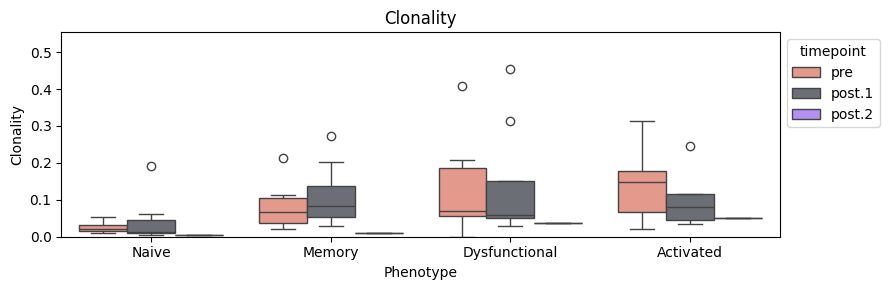

In [39]:
sub = adata[adata.obs["response"] == "Yes"]
tcri.pl.clonality(sub,groupby="patient",figsize=(9,3),splitby="timepoint",order=["Naive","Memory","Dysfunctional","Activated"])
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/clonality.pdf")

['Naive', 'Memory', 'Dysfunctional', 'Activated']


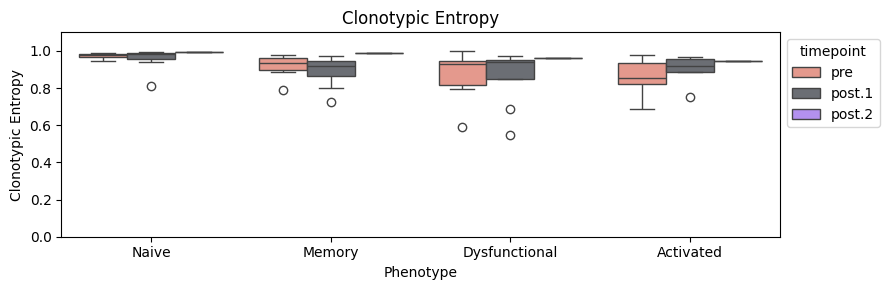

In [40]:
sub = adata[adata.obs["response"] == "Yes"]
tcri.pl.clonotypic_entropy(sub,groupby="patient",figsize=(9,3),method="probabilistic",splitby="timepoint",normalized=True,order=["Naive","Memory","Dysfunctional","Activated"])
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/clonotypic_entropy.pdf")

['Naive', 'Memory', 'Dysfunctional', 'Activated']


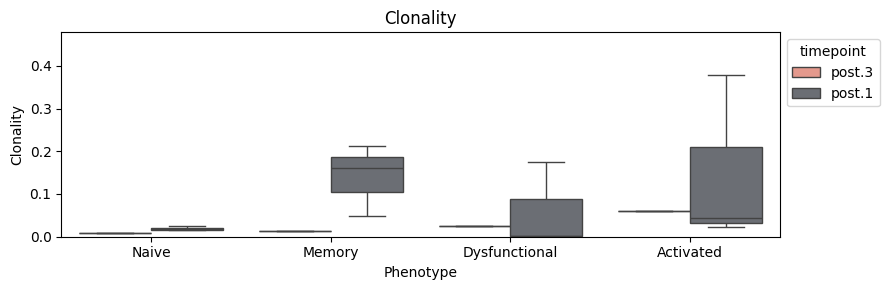

In [41]:
sub = adata[adata.obs["response"] == "No"]
tcri.pl.clonality(sub,groupby="patient",figsize=(9,3),splitby="timepoint",order=["Naive","Memory","Dysfunctional","Activated"])
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/clonality.pdf")

In [54]:
# set(adata[adata.obs["patient"] == "P1"].obs["timepoint"])
# set(adata[adata.obs["patient"] == "P1"].obs["response"])
# pdict = dict()
# for x in set(adata.obs["patient"]):
#     sub = adata[adata.obs["patient"] == x]
#     pdict[x] = []
#     for y in set(sub.obs["timepoint"]):
#         subsub = sub[sub.obs["timepoint"] == y]
#         for z in set(subsub.obs["response"]):
#             subsubsub = subsub[subsub.obs["response"]==z]
#             pdict[x].append((y,z))
# for x in pdict:
#     print(x, pdict[x])


['Memory', 'Activated', 'Naive', 'Dysfunctional']


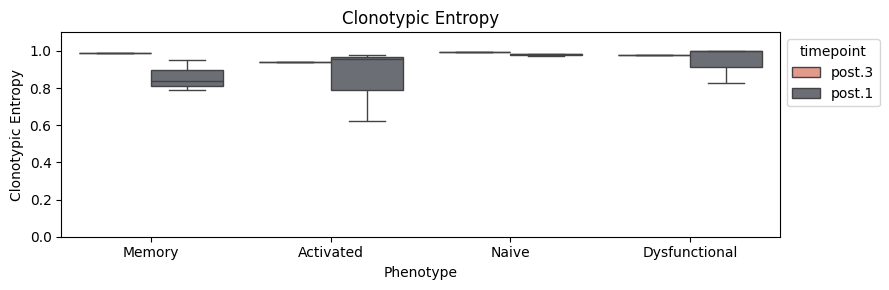

In [42]:
sub = adata[adata.obs["response"] == "No"]
tcri.pl.clonotypic_entropy(sub,groupby="patient",figsize=(9,3),method="probabilistic",splitby="timepoint",normalized=True)
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/clonotypic_entropy_no.pdf")

['Naive', 'Memory', 'Dysfunctional', 'Activated']


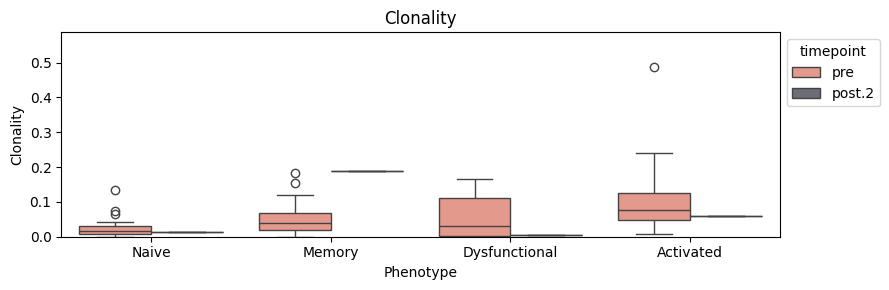

In [27]:
sub = adata[adata.obs["response"] == "None"]
tcri.pl.clonality(sub,groupby="patient",figsize=(9,3),splitby="timepoint",order=["Naive","Memory","Dysfunctional","Activated"])
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/clonality_tx_naive.pdf")

['Activated', 'Memory', 'Dysfunctional', 'Naive']


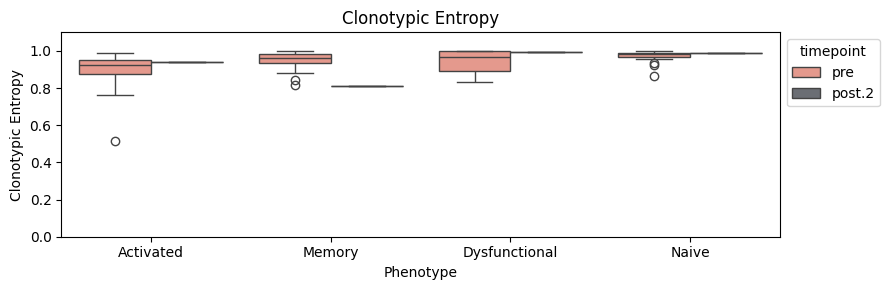

In [28]:
sub = adata[adata.obs["response"] == "None"]
tcri.pl.clonotypic_entropy(sub,groupby="patient",figsize=(9,3),method="probabilistic",splitby="timepoint",normalized=True)
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/clonotypic_entropy_none.pdf")

In [36]:
# sub[sub.obs["timepoint"] == "post.2"].obs["patient"]

sub = adata[adata.obs["patient"] == "P13"].obs["timepoint"]
set(sub.obs["timepoint"])

AttributeError: 'Series' object has no attribute 'obs'

In [51]:
tcri.tl.phenotypic_entropies(adata)

{'TGCACATTTAACTACTTTGGAAATGAGAAATTAACCTTT': 0.02458,
 'TGCACCACACCCCCAGGAACCTACAAATACATCTTT': 0.00337,
 'TGCACCCACGGGTTTTATGGAGGAAGCCAAGGAAATCTCATCTTT': 0.0028,
 'TGCACCCACTATATATCTAACTTTGGAAATGAGAAATTAACCTTT': 0.0,
 'TGCACCCAGAATGGTGGTGCTACAAACAAGCTCATCTTT': 0.00046,
 'TGCACCCCCCCCGGAGCTGCAGGCAACAAGCTAACTTTT': 0.99651,
 'TGCACCCGTCAAAATAACAATGACATGCGCTTT': 0.46206,
 'TGCACCCTCCATTCAGGAAACACACCTCTTGTCTTT': 0.00788,
 'TGCACCGATGCTGGTGGTACTAGCTATGGAAAGCTGACATTT': 0.57204,
 'TGCACGGGCAGGAGAGCACTTACTTTT': 0.99865,
 'TGCAGCGGAAGAGGTAGCAACTATAAACTGACATTT': 0.51033,
 'TGCAGGGCCGGTCGGCTCTGGGGCTGGGAGTTACCAACTCACTTT': 0.01019,
 'TGCAGGGGCTTTGGAAATGAGAAATTAACCTTT': 0.01033,
 'TGCATAACCTTCTCAGGAACCTACAAATACATCTTT': 0.99174,
 'TGCATAATAGTGCCCAATGCAGGCAAATCAACCTTT': 0.32626,
 'TGCATATCACAGCCTCCCAGCCCAGCCATGCAGGCATCTACCTCTGTGGAGTGTCTG': 0.0488,
 'TGCATCAAGTTTGAGGGAGGCTATGGAAAGCTGACATTT': 0.00146,
 'TGCATCACACACCGTCCCCAGGGAGCCCAGAAGCTGGTATTT': 0.99216,
 'TGCATCACCCCAGGCGGCGGCACTGCCAGTAAACTCACCTTT': 0.

In [76]:
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from statannot import add_stat_annotation
# import matplotlib.patches as mpatches

# from gseapy import dotplot
# import tqdm

# import collections
# import operator
# import itertools


# def flux(adata, key, order, groupby, method="probabilistic", paint=None, distance_metric="l1", figsize=(12,5)):
#     dfs = []
#     if paint != None:
#         palette = []
#         legend_handles = [] 
#         paint_categories = adata.obs[paint].unique()
#         pcolors = dict(zip(paint_categories, tcri.pl.tcri_colors))
#         for category in paint_categories:
#             handle = mpatches.Patch(color=pcolors[category], label=category)
#             legend_handles.append(handle)
#     else:
#         palette = tcri.pl.tcri_colors
#     for x in tqdm.tqdm(list(set(adata.obs[groupby]))):
#         sdata = adata[adata.obs[groupby]==x]
#         hue_order = []
#         for i in range(len(order)-1):
#             l1_distances = tcri.tl.flux(sdata,key=key,from_this=order[i],to_that=order[i+1],distance_metric=distance_metric)
#             df = pd.DataFrame(list(l1_distances.items()), columns=['Clone', distance_metric])
#             df[groupby] = x
#             if paint!=None:
#                 pcat = sdata.obs[paint].unique().tolist()[0]
#                 palette.append(pcolors[pcat])
#             df["Comparison"] = "{}_{}".format(order[i],order[i+1])
#             hue_order.append("{}_{}".format(order[i],order[i+1]))
#             dfs.append(df)
#     df = pd.concat(dfs)
#     df.replace([np.inf, -np.inf], np.nan, inplace=True)
#     df.dropna(inplace=True)
#     order = df.groupby(groupby).median(distance_metric).sort_values(distance_metric).index.tolist()
#     fig,ax=plt.subplots(1,1,figsize=figsize)
#     sns.boxplot(data=df,x=groupby,y=distance_metric,hue="Comparison",order=order,palette=palette,ax=ax, hue_order=hue_order)
#     if paint != None:
#         ax.legend(handles=legend_handles, title=paint)
#     fig.tight_layout()
#     return ax

sub = adata[adata.obs["clone_size"]>20]
tcri.pl.flux(sub, key="timepoint", order=["pre","post.1","post.2","post.3"], groupby="patient", method="probabilistic", distance_metric="dkl",figsize=(10,4))
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/flux_l1.pdf")

NameError: name 'tcri' is not defined

In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
import matplotlib.patches as mpatches

from gseapy import dotplot
import tqdm

import collections
import operator
import itertools
from tcri.pl import tcri_colors
from tcri.tl import clonotypic_entropies as centropies
from tcri.tl import clonality as clonality_tl
from tcri.tl import flux as flux_tl
from tcri.tl import mutual_information as mutual_information_tl
from tcri.tl import clone_fraction as clone_fraction_tl
from tcri.ut     import Phenotypes, CellRepertoire, Tcell, plot_pheno_sankey, plot_pheno_ternary_change_plots, draw_clone_bars
from tcri.pl import clone_size, joint_distribution

def phenotypic_flux(adata, splitby, order, clones=None, normalize=True, nt=True, phenotype_colors=None):
    phenotypes = Phenotypes(adata.obs[adata.uns["tcri_phenotype_key"]].unique())
    repertoires = dict()
    times = list(range(len(order)))
    for s in order:
        repertoires[s] = CellRepertoire(clones_and_phenos = {}, 
                                        phenotypes = phenotypes, 
                                        use_genes = False, 
                                        use_chain = False,
                                        seq_type = 'ntseq',
                                        chains_to_use = ['TRB'],
                                        name = s)
    for condition, seq, phenotype in zip(adata.obs[splitby],
                                         adata.obs[adata.uns["tcri_clone_key"]],
                                         adata.obs[adata.uns["tcri_phenotype_key"]]):
        if str(seq) != "nan" and condition in repertoires:
            if nt:
                t = Tcell(phenotypes = phenotypes, phenotypes_and_counts = {phenotype: 1}, 
                                                          TRB = dict(ntseq = seq), 
                                                          use_genes = False)
            else:
                t = Tcell(phenotypes = phenotypes, phenotypes_and_counts = {phenotype: 1}, 
                                                          TRB = dict(aaseq = seq), 
                                                          use_genes = False)
            repertoires[condition].cell_list.append(t)
    for condition, rep in repertoires.items():
        rep._set_consistency()
    if phenotype_colors==None:
        phenotype_colors = dict(zip(set(adata.obs[adata.uns["tcri_phenotype_key"]]), tcri_colors))
    fig, ax = plot_pheno_sankey(phenotypes = phenotypes, 
                                cell_repertoires = [repertoires[condition] for condition in order], 
                                clones = clones,
                                times = times,
                                xlim = [min(times), max(times)],
                                time_rescale = 1,
                                normalize=normalize,
                                xlabel = splitby,
                                return_axes = True, 
                                show_legend = True,
                                phenotype_colors=phenotype_colors)
    ax.set_xticks(times)
    ax.set_xticklabels(order)

In [57]:
phenotype_colors = dict(zip(set(adata.obs[adata.uns["tcri_phenotype_key"]]), tcri_colors[5:]))

In [192]:
sub[sub.obs["response"] == "No"].obs["timepoint"]


tcri.pl.phenotypic_flux(sub,splitby="timepoint",order=["pre","post.1","post.2","post.3"],nt=False,normalize=False,phenotype_colors=phenotype_colors, figsize=(12,5))

Series([], Name: timepoint, dtype: category
Categories (0, object): [])

{'No', 'Yes'}
     timepoint                          Category         Value
0          pre          Naive Pseudo-probability  9.170366e-01
1          pre          Naive Pseudo-probability  6.084863e-03
2          pre          Naive Pseudo-probability  1.389751e-12
3          pre          Naive Pseudo-probability  2.279031e-06
4          pre          Naive Pseudo-probability  3.555142e-03
...        ...                               ...           ...
2155    post.2  Dysfunctional Pseudo-probability  4.368297e-01
2156    post.2  Dysfunctional Pseudo-probability  3.436101e-01
2157    post.2  Dysfunctional Pseudo-probability  1.714172e-04
2158    post.2  Dysfunctional Pseudo-probability  4.442400e-06
2159    post.2  Dysfunctional Pseudo-probability  3.659333e-01

[2160 rows x 3 columns]


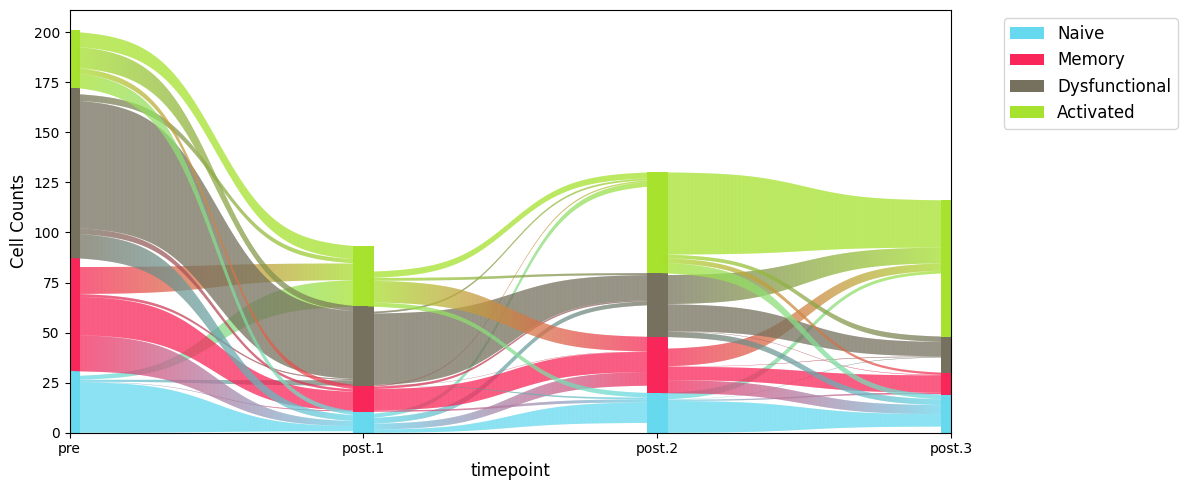

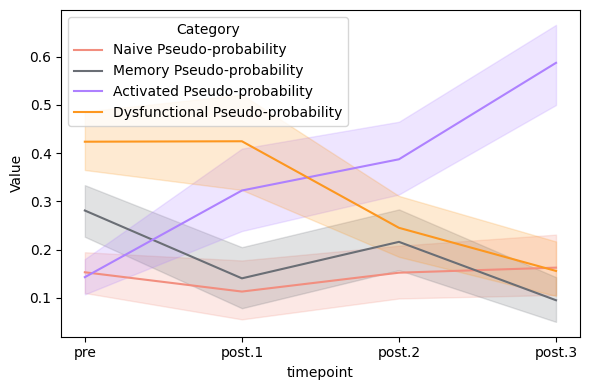

In [105]:
sub = adata[adata.obs["patient"] == "P1"]
sub = sub[sub.obs["clone_size"]>15]
print(set(sub.obs["response"]))
tcri.pp.joint_distribution(sub)

plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/zhang_p1_sankey.pdf")

df = sub.obs[["timepoint"]+sub.uns["probability_columns"]]
order=["pre","post.1","post.2","post.3"]
df['timepoint'] = pd.Categorical(df['timepoint'], categories=order, ordered=True)
df_long = df.melt(id_vars='timepoint', var_name='Category', value_name='Value')
print(df_long)
fig,ax=plt.subplots(1,1,figsize=(6,4))
sns.lineplot(data=df_long,x="timepoint",y="Value",hue="Category",ax=ax)
fig.tight_layout()

{'None', 'Yes'}
     timepoint                          Category         Value
0          pre          Naive Pseudo-probability  2.510302e-04
1          pre          Naive Pseudo-probability  3.999363e-03
2          pre          Naive Pseudo-probability  9.995544e-01
3          pre          Naive Pseudo-probability  2.235872e-04
4          pre          Naive Pseudo-probability  6.928853e-02
...        ...                               ...           ...
2931    post.2  Dysfunctional Pseudo-probability  6.078470e-06
2932    post.2  Dysfunctional Pseudo-probability  9.437256e-05
2933    post.2  Dysfunctional Pseudo-probability  2.011575e-08
2934    post.2  Dysfunctional Pseudo-probability  3.953970e-03
2935    post.2  Dysfunctional Pseudo-probability  1.054158e-03

[2936 rows x 3 columns]


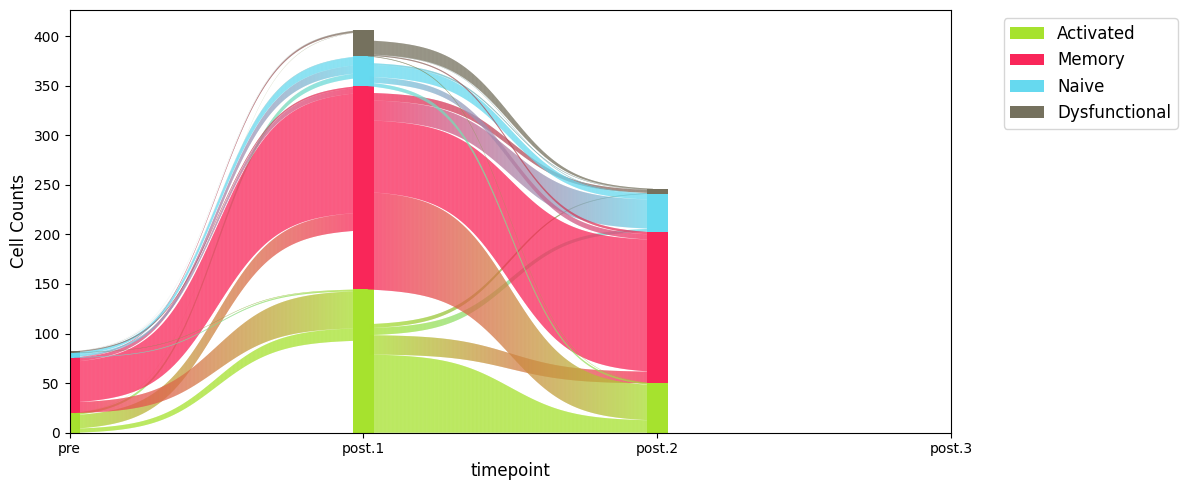

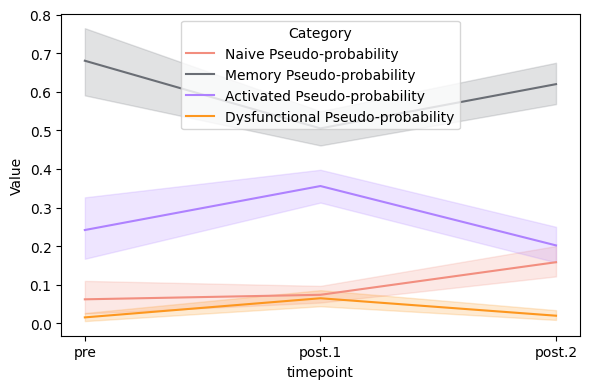

In [190]:
sub = adata[adata.obs["patient"] == "P13"]
sub = sub[sub.obs["clone_size"]>15]
print(set(sub.obs["response"]))
tcri.pp.joint_distribution(sub)
tcri.pl.phenotypic_flux(sub,splitby="timepoint",order=["pre","post.1","post.2","post.3"],nt=False,normalize=False,phenotype_colors=phenotype_colors,figsize=(12,5))
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/zhang_p13_sankey.pdf")

df = sub.obs[["timepoint"]+sub.uns["probability_columns"]]
order=["pre","post.1","post.2","post.3"]
df['timepoint'] = pd.Categorical(df['timepoint'], categories=order, ordered=True)
df_long = df.melt(id_vars='timepoint', var_name='Category', value_name='Value')
print(df_long)
fig,ax=plt.subplots(1,1,figsize=(6,4))
sns.lineplot(data=df_long,x="timepoint",y="Value",hue="Category",ax=ax,color=color)
fig.tight_layout()


In [188]:
pcolors = dict()
color = []
for x,y in phenotype_colors.items():
    pcolors[x + " Pseudo-probability"] = y
    color.append(y)


100%|██████████| 2/2 [00:00<00:00, 15.54it/s]


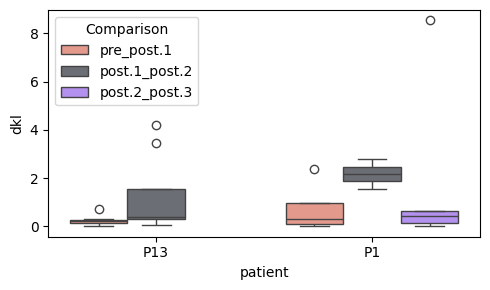

In [111]:
sub = adata[adata.obs["patient"].isin(["P13","P1"])]
sub = sub[sub.obs["clone_size"]>25]
flux(sub, key="timepoint", order=["pre","post.1","post.2","post.3"], groupby="patient", method="probabilistic", distance_metric="dkl",figsize=(5,3))
plt.savefig("/Users/ceglian/Data/tcri/zhang/figures/dkl_response.pdf")

[0.06400288922510547, 0.044595969126105736, 0.0028296081044968386]
[0.031779612472209645, 2.9757910977562113e-08, 0.1432338402674869]
[0.19047198928689463, 0.002147254097033246, 0.5565255947561026]
[0.047234939116192094, 4.7008682471520846e-05, 3.431211988893942e-05]
[0.017826231782828494, 0.3561783162529715, 0.0005273194711973634]
[0.14263680266912201, 0.24913461781832968, 0.0023625857471987768]
[0.00015406186089429754, 0.0008955378143748926, 6.148077340904669e-05]
[0.11325953836287482, 0.12456775715199218, 0.002399037676957097]
[0.45421774306301, 0.544519784372874, 0.5232998033999713]
[0.010061855465647106, 2.4839988973764265e-05, 0.0008039700646222547]
[0.9897975962366747, 0.2897947540267636, 0.9917763662062324]
[0.08333111718676801, 0.6140986412193328, 0.4966912723131503]
[0.07953623414411937, 0.10579422933857226, 2.369568537862593e-06]
[0.001975253509081101, 0.0004484055220478803, 0.00028922828406208493]
[0.19453583762462967, 0.11947106991166463, 0.00034006496614911444]
[8.1108833

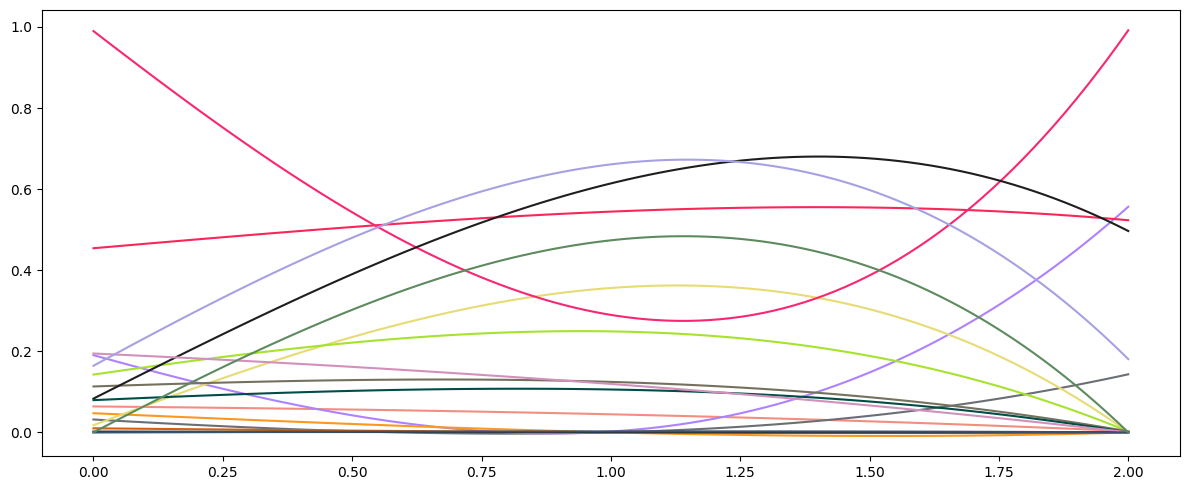

In [183]:
tcri.pl.clonality(adata,)

In [165]:
series

[0.06400288922510547, 0.044595969126105736, 0.0028296081044968386]

In [166]:
xs

[0, 0, 0]